<a href="https://colab.research.google.com/github/Hrich77/battle_snake/blob/main/CSE_4633_6633_HW_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSE 4633/6633 HW 3

The assignment for this notebook is to use probabilistic methods to perform modeling, prediction, and generation for the domain of fashion images. Recognition of images is an important component of many AI applications such as web search, automatic captioning, and sorting. This notebook is divided into 3 parts:

*   Part A: Modeling the probability distribution of fashion images
*   Part B: Image classification using the Naive Bayes classifier
*   Part C: Artificially generating new images



In [2]:
# import required libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [3]:
# Load the MNIST dataset
from keras.datasets import fashion_mnist
(x_train, c_train), (x_test, c_test) = fashion_mnist.load_data()

print("Loaded", len(x_train), "training samples and", len(x_test), "test samples")
print("x_train is a %dx%dx%d array of %s values ranging from %d to %d" % (x_train.shape[0], x_train.shape[1], x_train.shape[2], str(x_train.dtype), np.min(x_train), np.max(x_train)))
print("c_train is a %d-length array of %s values ranging from %d to %d" % (c_train.shape[0], str(c_train.dtype), np.min(c_train), np.max(c_train)))
print("x_test is a %dx%dx%d array of %s values ranging from %d to %d" % (x_test.shape[0], x_test.shape[1], x_test.shape[2], str(x_test.dtype), np.min(x_test), np.max(x_test)))
print("c_test is a %d-length array of %s values ranging from %d to %d" % (c_test.shape[0], str(c_test.dtype), np.min(c_test), np.max(c_test)))


Loaded 60000 training samples and 10000 test samples
x_train is a 60000x28x28 array of uint8 values ranging from 0 to 255
c_train is a 60000-length array of uint8 values ranging from 0 to 9
x_test is a 10000x28x28 array of uint8 values ranging from 0 to 255
c_test is a 10000-length array of uint8 values ranging from 0 to 9


In [4]:
# Label-mapping for Fashion MNIST dataset
label_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

Text(0.5, 1.0, 'Image of a Ankle Boot')

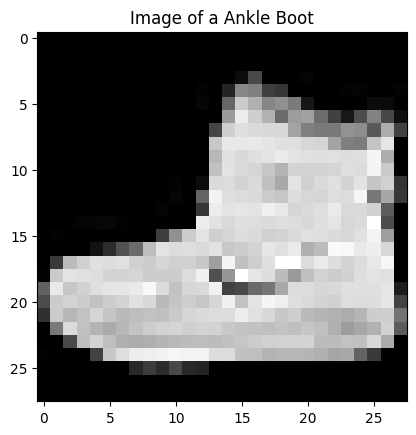

In [5]:
# Visualize the first image in the training dataset
first_image = x_train[0, :]
first_label = c_train[0]

# Use the plt.imshow function to plot an image
plt.imshow(first_image, cmap="gray")
plt.title("Image of a %s" % label_map[first_label])

# Part A: Modeling 

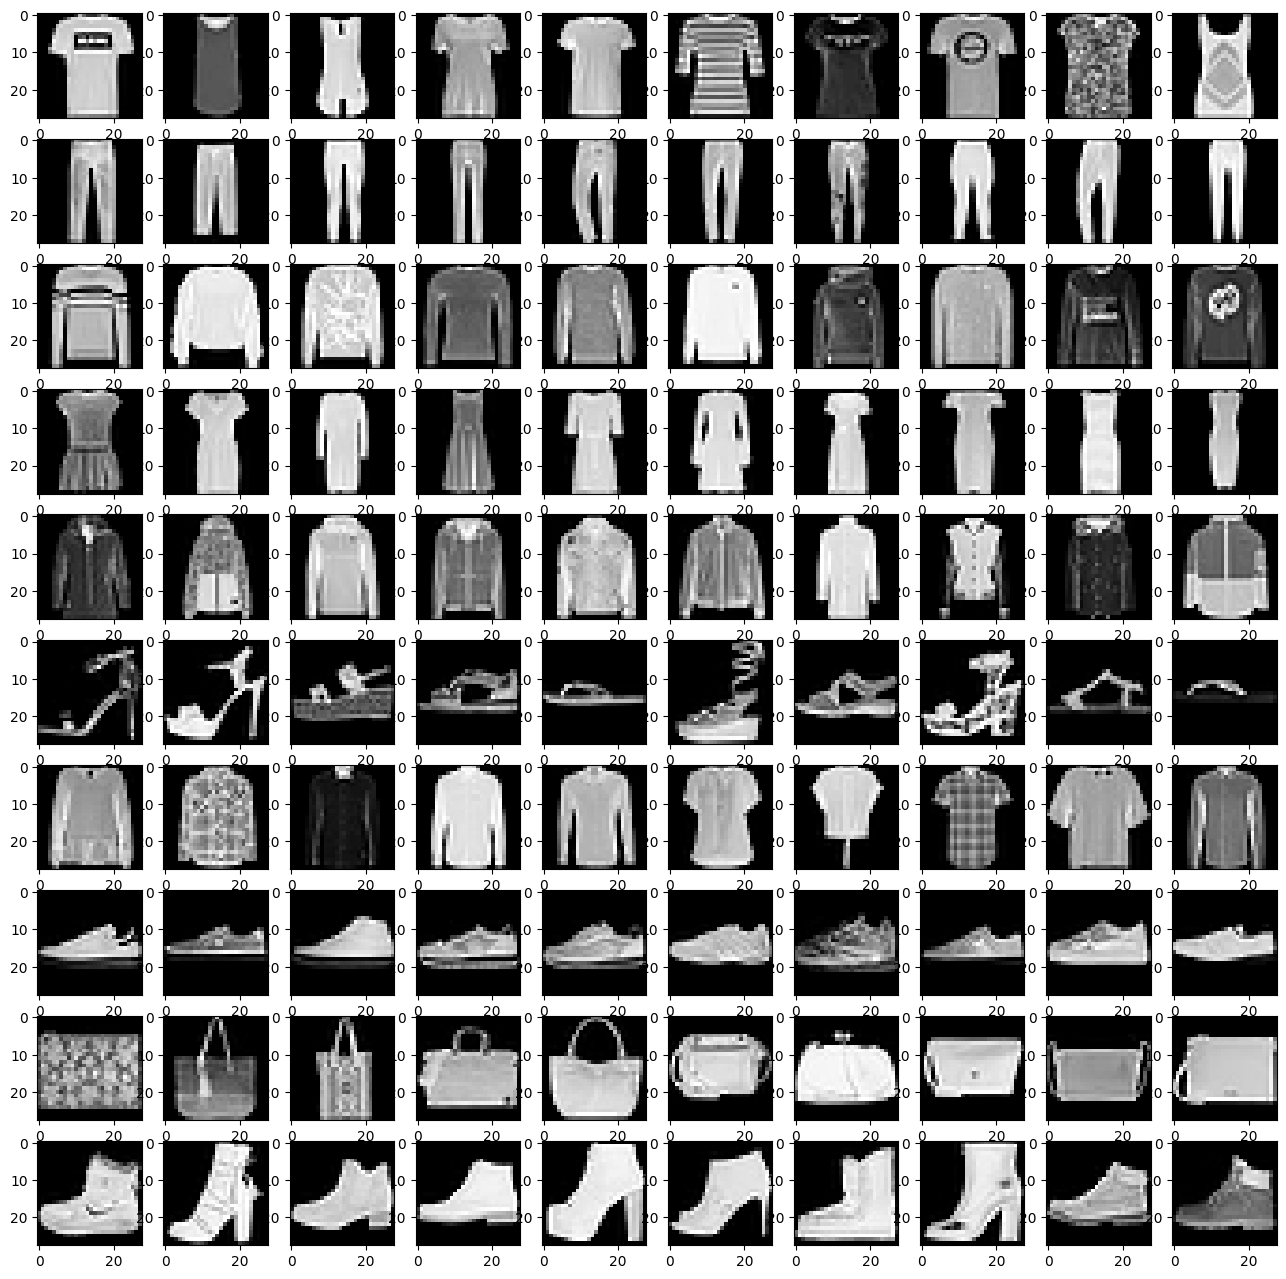

In [6]:
# TODO: Visualize the first 10 samples of each of the 10 classes from the training images
plt.figure(figsize=(16,16))

# Create a dictionary to keep track of the number of images plotted for each label
num_images = {label: 0 for label in label_map}

for i in range(60000):
    label = c_train[i]
    if num_images[label] < 10:
        if label_map[label]:
            plt.subplot(10, 10, label*10 + num_images[label] + 1)
            img = x_train[i]
            plt.imshow(img, cmap="gray")
            num_images[label] += 1
    else:
        # Break out of the loop once 10 images have been plotted for each label
        all_done = all(num_images[label] == 10 for label in label_map)
        if all_done:
            break


In [7]:
# TODO: model the pixel intensities as Gaussian distributions
# Calculate the mean and variance of each pixel location in an image conditioned on a certain class
# There should be 28 x 28 = 784 features for each image where each pixel is a feature
import numpy as np

# Calculate the mean and variance of each pixel location for each class
means = np.zeros((10, 28, 28))
variances = np.zeros((10, 28, 28))

for i in range(10):
    class_images = x_train[c_train == i]
    means[i] = np.mean(class_images, axis=0)
    variances[i] = np.var(class_images, axis=0)

# Model the pixel intensities as Gaussian distributions
def gaussian_prob(x, mean, variance):
    """
    Compute the probability density function of a Gaussian distribution.
    
    Parameters:
    x (float): The input value.
    mean (float): The mean of the distribution.
    variance (float): The variance of the distribution.
    
    Returns:
    float: The probability density function value.
    """
    return np.exp(-0.5 * ((x - mean) ** 2 / variance)) / np.sqrt(2 * np.pi * variance)

# Calculate the probability density function of each pixel for each class
pixel_probs = np.zeros((10, 28, 28, 256))

for i in range(10):
    for j in range(28):
        for k in range(28):
            pixel_probs[i, j, k] = gaussian_prob(np.arange(256), means[i, j, k], variances[i, j, k])


<ipython-input-7-102f46422483>:28: RuntimeWarning: divide by zero encountered in true_divide
  return np.exp(-0.5 * ((x - mean) ** 2 / variance)) / np.sqrt(2 * np.pi * variance)
<ipython-input-7-102f46422483>:28: RuntimeWarning: invalid value encountered in true_divide
  return np.exp(-0.5 * ((x - mean) ** 2 / variance)) / np.sqrt(2 * np.pi * variance)


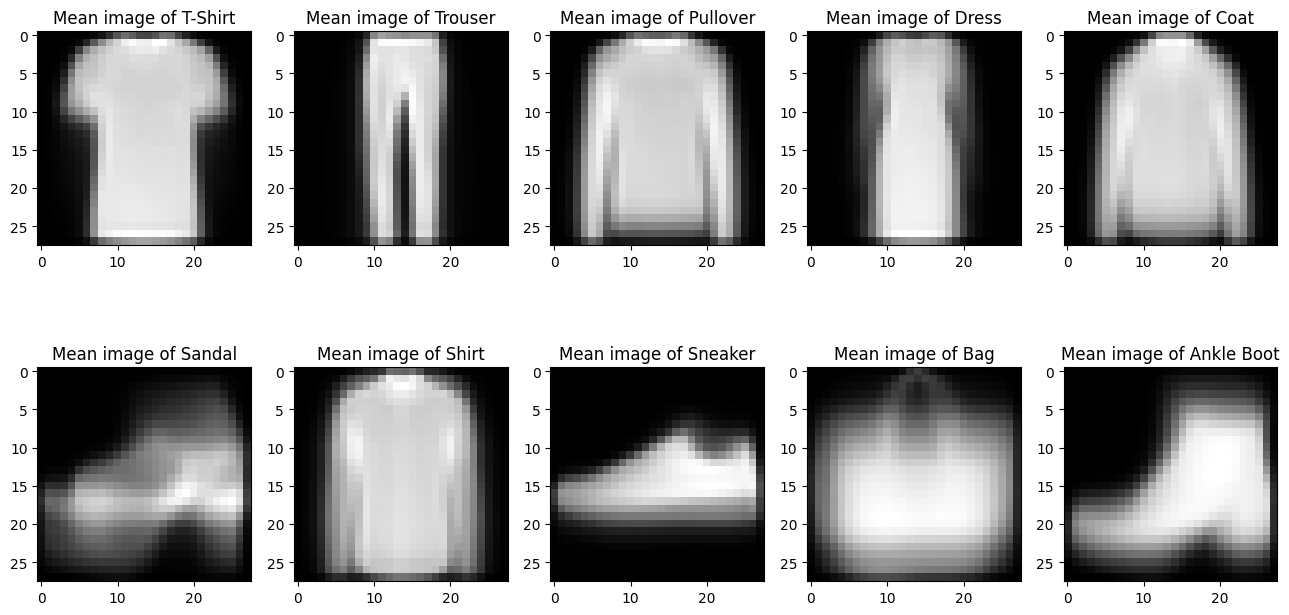

In [8]:
# Visualize the mean image of each class
plt.figure(figsize=(16,8))
for i in range(10):
    plt.subplot(2,5, i+1)
    img = means[i].reshape(28, 28)
    plt.imshow(img, cmap="gray")
    plt.title('Mean image of %s' % label_map[i], fontsize = 12)

In [9]:
# TODO: determine the distribution of classes
P_c = np.zeros(10)
for i in num_images:
  P_c[i] += num_images[i]
print('P_c:', P_c)

P_c: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


Text(0, 0.5, 'P(c)')

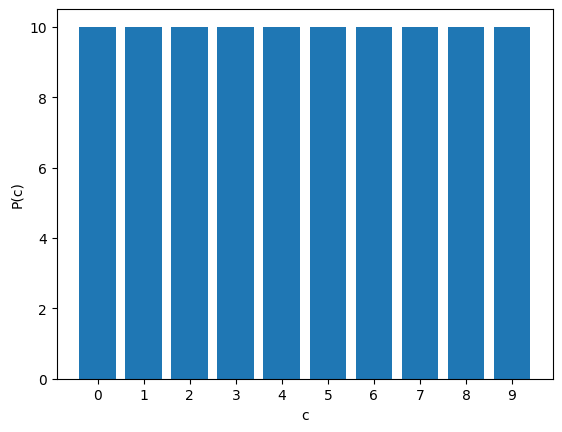

In [10]:
# Plot the distribution of classes as a bar chart
plt.bar(range(10), P_c)
plt.gca().set_xticks(range(10))
plt.xlabel("c")
plt.ylabel("P(c)")

# Part B: Prediction

In [11]:
# Step 1: Regularize the variances by adding a constant (e.g. 1000)
variances_reg = variances + 1000
# Calculate the prior probabilities of each class
counts = np.bincount(c_train)
priors = counts / len(c_train)

# Step 2: For each test image and for each class, calculate log P(x | c) using the univariate Gaussian formula
log_probs = np.zeros((len(x_test), 10))
for i in range(len(x_test)):
    for j in range(10):
        log_probs[i,j] = np.sum(np.log(gaussian_prob(x_test[i].flatten(), means[j].flatten(), variances_reg[j].flatten())))

# Step 3: For each test image and for each class, calculate log P(x | c) + log P(c)
log_joint_probs = log_probs + np.log(priors)

# Step 4: For each test image, determine the predicted class based on maximizing the previous formula
predictions_nb = np.argmax(log_joint_probs, axis=1)


In [12]:
# Calculate the accuracy of our predictions
accuracy = np.sum(predictions_nb == c_test) / len(c_test)
print("Overall accuracy for Naive-Bayes is %.3f" % accuracy)

Overall accuracy for Naive-Bayes is 0.672


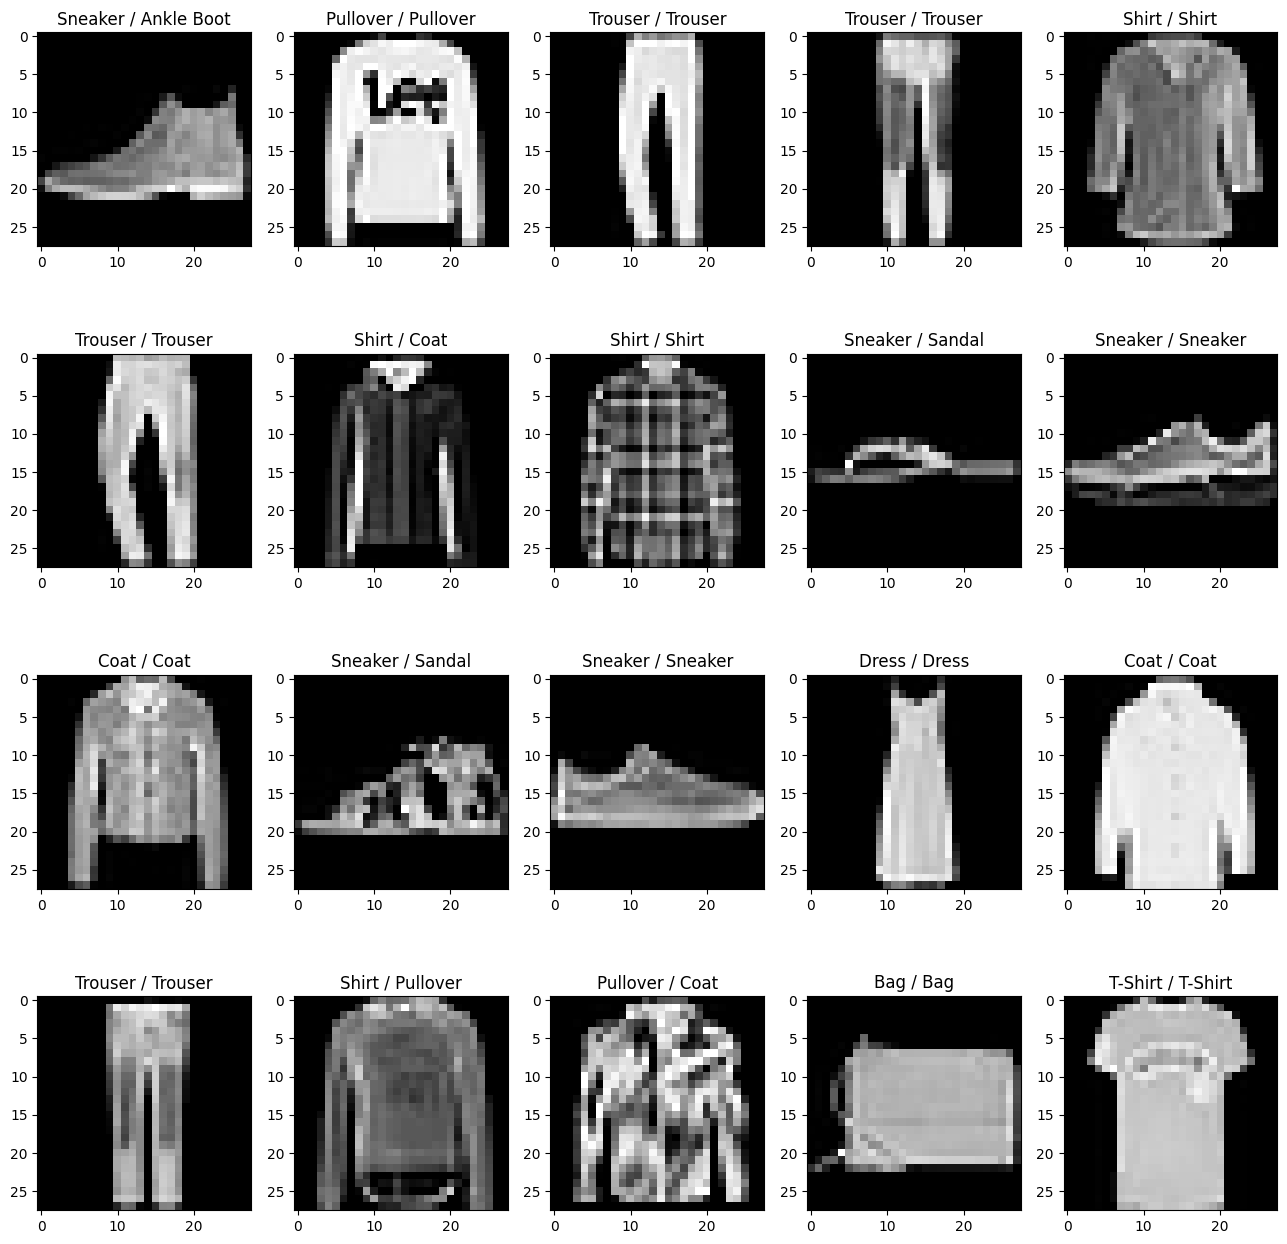

In [13]:
# Visualize a few test samples along with their predicted classes
plt.figure(figsize=(16,16))
for i in range(20):
  plt.subplot(4, 5, i+1)
  plt.imshow(x_test[i], cmap="gray")
  plt.title("%s / %s" % (label_map[predictions_nb[i]], label_map[c_test[i]]))

In [14]:
# Function for evaluating the log probability density function at x
# for a multivariate normal distribution with given mean and covariance
# https://gregorygundersen.com/blog/2020/12/12/group-multivariate-normal-pdf/
# x: N-length 1D array
# mean: N-length 1D array
# cov: N x N 2D array
def multivariate_normal_logpdf(x, mean, cov):
    vals, vecs = np.linalg.eigh(cov)
    logdet     = np.sum(np.log(vals))
    valsinv    = 1./vals
    U          = vecs * np.sqrt(valsinv)
    dim        = len(vals)
    dev        = x - mean
    maha       = np.square(np.dot(dev, U)).sum(axis=-1)
    log2pi     = np.log(2 * np.pi)
    return -0.5 * (dim * log2pi + maha + logdet)

In [ ]:
# Step 1: Calculate the 784x784 covariance matrix of each class from the training data
covariances = np.zeros((10, 784, 784))
for i in range(10):
    indices = np.where(x_train == i)[0]
    covariances[i] = np.cov(x_train[indices].T)

# Step 2: Regularize the covariances by adding an identity matrix multiplied by a constant
const = 1000
for i in range(10):
    covariances[i] += const * np.identity(784)

# Step 3: Calculate log P(x | c) for each test image and for each class
log_likelihoods = np.zeros((10000, 10))
for i in range(10000):
    for j in range(10):
        log_likelihoods[i, j] = multivariate_normal_logpdf(x_test[i], means[j], covariances[j])

# Step 4: Calculate log P(x | c) + log P(c) for each test image and for each class
log_posteriors = log_likelihoods + log_priors

# Step 5: Determine the predicted class for each test image
predictions = np.argmax(log_posteriors, axis=1)


In [ ]:
# Calculate the accuracy of our predictions
accuracy = np.sum(predictions_nnb == c_test) / len(c_test)
print("Overall accuracy for non-Naive-Bayes is %.3f" % accuracy)

In [ ]:
# Visualize a few test samples along with their predicted classes
plt.figure(figsize=(16,16))
for i in range(20):
  plt.subplot(4, 5, i+1)
  plt.imshow(x_test[i], cmap="gray")
  plt.title("%s / %s" % (label_map[predictions_nnb[i]], label_map[c_test[i]]))

# Part C: Generation

In [1]:
samples = []
for i in range(10):
    means = np.zeros((10, 28*28))
    # Generate 10 random feature vectors from the i-th multivariate Gaussian model
    covariances = np.zeros((10, 28*28, 28*28))
    x = np.random.multivariate_normal(means[i], covariances[i], size=10)
    # Convert each feature vector into a 28x28 image
    images = np.clip(np.resize(x, (10, 28, 28)), 0, 255).astype('uint8')
    # Add the images to the list of samples
    samples.append(images)

# Display the resulting images
plt.figure(figsize=(16,16))
for i in range(10):
    for j in range(10):
        plt.subplot(10, 10, i*10 + j +1)
        plt.imshow(samples[i][j], cmap="gray")
plt.show()


NameError: ignored